Project for the course in Microeconometrics | Summer 2020, M.Sc. Economics, Bonn University | Felix Kirsch

<h1>Replication of Angrist and Krueger (1991)</h1>

<h2>Introduction</h2>

Angrist and Krueger present estimates of the return to education using season of birth as instrument for school attendance. The relation of season of birth to school attendance is caused by interaction of compulsory schooling laws and school enrollment policies. Compulsory schooling attendance prohibits students to drop out of school before they have reached a certain age. Normaly, school enrollment policies require students to have passed the age of six at the beginning of the year in which they start to attend school. Therefore, students who are born at the beginning of the year start school at an older age than those who are born later in the year. In combination with the compulsory school attendance laws this enables individuals born at the beginning of the year to drop out of school with less years of schooling. Under the assumption that the fraction of students who want to leave school is independent from season of birth, students born later in the year are constrained to attend school longer. So, compulsory schooling laws introduce  a variation of school attendance dependening on the season of birth. Since time of birth is most likely uncorrelated to other personal characteristics, Angrist and Krueger use the variation to estimate the return to education.

In the first section of their paper, the authors examine the relation between years of education and season of birth using data from the 1980 US Census. They investigate the effect of quarter of birth on various educational outcome variables.
In the second section, the return to education is estimated using a two stage least squares approach. Thereby, quarter of birth is used as instrument for years of education. Angrist and Krueger present various results, comparing OLS and TSLS and using different control variables.

In the following I will present a replication of the results of Angrist and Krueger.

In [1]:
import matplotlib
import numpy as np
from operator import itemgetter
import pandas as pd
import patsy
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.display import HTML, Image

import auxiliary.data_helper as dhlp
import auxiliary.figures as fgrs
import auxiliary.tables as tbl
import auxiliary.regressions as rgr

pd.set_option('precision', 2)
matplotlib.rcParams['figure.figsize'] = [10, 5]

# 2. Theoretical Background

# 3. Identification

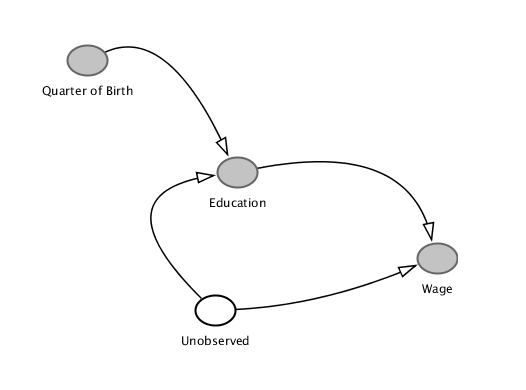

In [10]:
Image('files/causal_graph_angrist.png')

# 4. Empirical Strategy

# 5. Replication of Angrist and Krueger (1991)

<h3>Data & Descriptive Statistics</h3>

The results of Angrist and Krueger are mostly based on micro data from the 1980 Census (link to documentation, Census of Population and Hosuing, 1980: Public Use Microdata). They created an extract from the 5 percent Public Use Sample, which is a self-weighting sample of 5 percent of the population as of April 1, 1980. These extract is provided here , and is used for the following replications.

The extract contains white and black men born in the United States between 1930 - 1959. It contains the quarter of birth (QOB), the year of birth (YOB), the age and the age accurate to the quarter of birth (AGEQ). The education variable describes years of completed schooling. There are 8 dummies for region of residence (ENOCENT, ESOCENT, MIDATL, MT, NEWENG, SOATL, WNOCENT, WSOCENT), 3 dummies for race (RACE, 1 = black), for martial status(MARRIED, 1 = married) and standard metropolitan staticstical area (SMSA, 1 = city center). Furthermore, the state variable describes the state of birth.

For most purposes the authors divide the data of the extract in two cohorts, men born from 1930-39 and men born form 1940-49. In most applications these groups are examined seperatly. Therefore, for both cohort descriptive statistics are presented.

In [2]:
# 
df = dhlp.get_df_census80_extract()

cohort30 = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
cohort40 = df.loc[(df['YOB'] >= 40) & (df['YOB'] <= 49)]

In [3]:
# summary statistics for 1930 - 39 Births
cohort30.describe().loc[['mean', 'std', 'min', 'max']]

,AGE,AGEQ,EDUC,ENOCENT,ESOCENT,LWKLYWGE,MARRIED,MIDATL,MT,NEWENG,CENSUS,STATE,QOB,RACE,SMSA,SOATL,WNOCENT,WSOCENT,YOB
mean,44.65,45.02,12.77,0.2,0.07,5.90,0.86,0.16,0.05,0.06,80.0,30.69,2.51,0.08,0.19,0.17,0.08,0.1,34.6
std,2.94,2.92,3.28,0.4,0.25,0.68,0.34,0.37,0.22,0.23,0.0,14.22,1.11,0.27,0.39,0.37,0.27,0.3,2.9
min,40.00,40.25,0.00,0.0,0.00,-2.34,0.00,0.00,0.00,0.00,80.0,1.00,1.00,0.00,0.00,0.00,0.00,0.0,30.0
max,50.00,50.00,20.00,1.0,1.00,10.53,1.00,1.00,1.00,1.00,80.0,56.00,4.00,1.00,1.00,1.00,1.00,1.0,39.0


In [4]:
# summary statistics for 1940 - 49 Births
cohort40.describe().loc[['mean', 'std', 'min', 'max']]

,AGE,AGEQ,EDUC,ENOCENT,ESOCENT,LWKLYWGE,MARRIED,MIDATL,MT,NEWENG,CENSUS,STATE,QOB,RACE,SMSA,SOATL,WNOCENT,WSOCENT,YOB
mean,34.32,34.69,13.57,0.2,0.07,5.80,0.8,0.15,0.05,0.06,80.0,30.13,2.54,0.08,0.19,0.17,0.08,0.1,44.92
std,2.87,2.86,2.98,0.4,0.25,0.65,0.4,0.36,0.22,0.23,0.0,14.53,1.12,0.27,0.39,0.38,0.27,0.3,2.84
min,30.00,30.25,0.00,0.0,0.00,-2.34,0.0,0.00,0.00,0.00,80.0,1.00,1.00,0.00,0.00,0.00,0.00,0.0,40.00
max,40.00,40.00,20.00,1.0,1.00,11.23,1.0,1.00,1.00,1.00,80.0,56.00,4.00,1.00,1.00,1.00,1.00,1.0,49.00


<h3>Season Of Birth, Compulsory Schooling, And Years Of Education</h3>

Students born in beginning of the year are allowed the leave school earlier than students born in the end of the year. Since all students start school at the same time, students born in the first quarter of the year can drop out of school with less years of schooling than students born in the other quarters. If the portion of individuals who like to leave school is the same for all quarters, quarter of birth and years of schooling would correlate. Students born earlier in the year would have less schooling than students born later.
The following figures show the relationship between the years of education and season of birth for the 1930-39 and the 1940-49 cohort. The graph displays the average years of completed education. The number und the observations describe the quarter of birth.

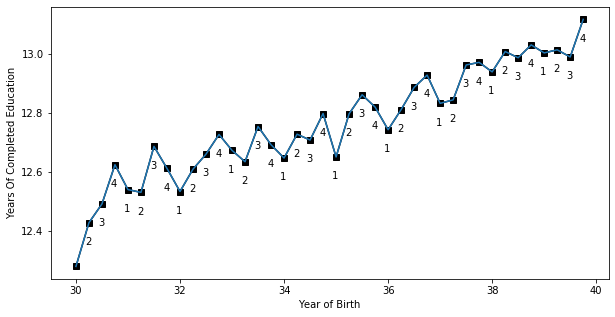

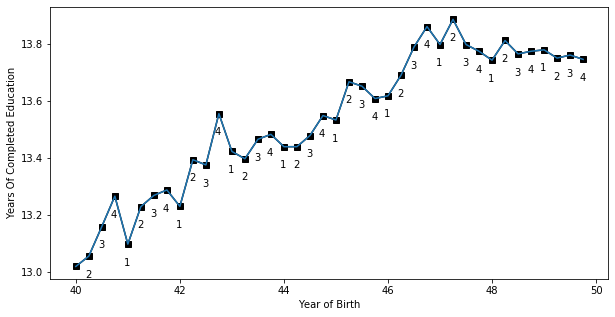

In [5]:
fgrs.plot_educ_against_yob(cohort30)
fgrs.plot_educ_against_yob(cohort40)

In the first figure the curve has an increasing trend and follows a reoccuring pattern. The average of completed years of education is lower for early quarters in the year and higher for late quarters. Most times the fourth quarter is higher than the first quarter of the following year.
In the second figure this pattern is also recognizable but not as pronounce as in the figure. The curve has an increasing trend untill 1948, then it flattens.

For further examination of these pattern Angrist and Krueger remove the trend inside the observations. The detrended average is computed by subtracting a moving average. This two-sided moving average is computed for each quarter using the average education of the two previous and the two following quarters:

$$ MA_{cj} = (E_{-2} + E_{-1} + E_{+1} + E_{+2}) / 4 $$

$MA_{cj}$ is the moving average for students born in year $c$ and quarter $j$. $E_q$ is the average education for students born $q$ quarters before or after. Then, the detrended average is $E_{cj} - MA_{cj}$.

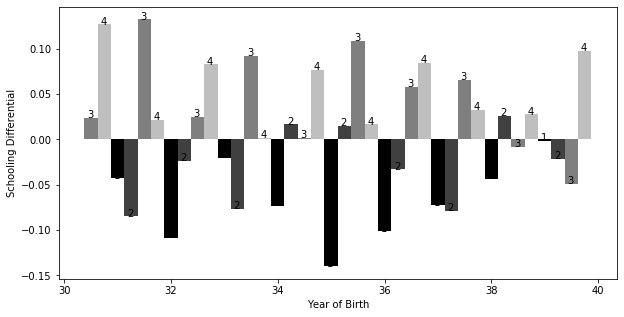

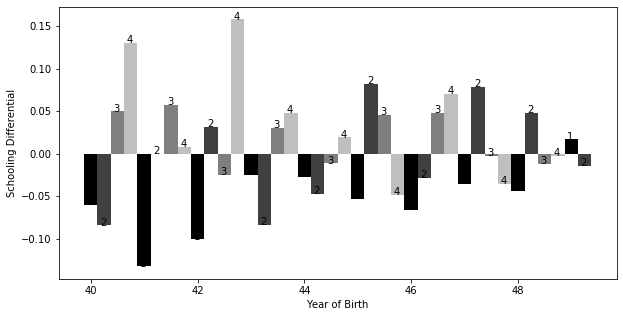

In [6]:
mean_educ = df.groupby(['YOB', 'QOB'])['EDUC'].mean().to_frame()
mean_educ['MV_AVG'] = dhlp.two_sided_moving_average(mean_educ.values)
mean_educ['DTRND'] = mean_educ['EDUC'] - mean_educ['MV_AVG']

fgrs.plot_bar_detrended_educ(mean_educ.loc[range(30, 40)])
fgrs.plot_bar_detrended_educ(mean_educ.loc[range(40, 50)])

The figures above show how quarter of birth and detrended average education are related. The plots indicate that season of birth is related to years of completed education. For all but one first quarter the schooling differential is negative, and most of the third and fourth quarters have a positive schooling differential.

To quantify the effect of quarter of birth on completed years of education Angrist and Krueger calculate regressions, using the following formula:

$$(E_{icj} - MA_{cj}) = \alpha + \sum^{3}_{j}{\beta_{j} Q_{icj}} + \epsilon_{icj}$$
$$for \space i = 1, \dots, N_{c}; \space c = 1, \dots , 10; \space j = 1, 2, 3;$$

$E_{icj}$ represents the educational outcome variable for individual $i$ in cohort $c$. The authors run regressions on total years of education, high school graduation, years of education for high school graduates, college graduation, completed master's degree and completed doctoral degree. $MA_{cj}$ is the two-period, two-sided moving average of the corresponding outcome variable. $Q_{icj}$ is a dummy variable, which specifies if individual $i$ was born in the $j$th quarter of the year.
By construction of the moving average, it is necessary to exclude the first two and the last two observations from the regressions.

In [7]:
educ_vars = ['EDUC', 'DUMMY_HIGH_SCHOOL', 'DUMMY_COLLEGE', 'DUMMY_MASTER', 'DUMMY_DOCTOR']

df = dhlp.add_quarter_of_birth_dummies(df)
df = dhlp.add_education_dummies(df)
df = dhlp.add_detrended_educational_variables(df, educ_vars = educ_vars)

cohort30 = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)].dropna()
cohort40 = df.loc[(df['YOB'] >= 40) & (df['YOB'] <= 49)].dropna()

cohorts = [('1930-1939', cohort30), ('1940-1949', cohort40)]

results = rgr.get_regression_results_educational_variables(educ_vars, cohorts)

cohort30_high_school = cohort30.loc[cohort30['DUMMY_HIGH_SCHOOL'] == 1]
cohort40_high_school = cohort40.loc[cohort40['DUMMY_HIGH_SCHOOL'] == 1]

cohorts_high_school = [('1930-1939', cohort30_high_school), ('1940-1949', cohort40_high_school)]

results[4:4] = rgr.get_regression_results_educational_variables(['EDUC'], cohorts_high_school)

HTML(tbl.create_table_qob(results, outcome_variables = ['Total years of education', '', \
                                                        'High school graduate', '', \
                                                        'Years of educ. for high school graduates', '', \
                                                        'College graduate', '', \
                                                        "Completed master's degree", '', \
                                                        'Completed doctoral degree', '']))

The estimates in the table show the effect of quarter of birth on the outcome variable relative to individuals born in the fourth quarter. For each outcome variable regressions are made for men born between 1930-39 and men born between 1940-49. The standard errors are in parantheses below the estimates. The result of the F-Test is for the test if all quarter-of-birth dummies have jointly no effect.
For the educational outcome variables the authors make the assummption, that individuals with sixteen or more years of education have a college degree, individuals with eightteen or more years of education have a master's degree and individuals with twenty or more years of education have a doctoral degree.

The regressions show that men born in the first quarter have an lower average number of schooling years relative to men born in the fourth quarter. Also, men born in the first quarter are less likely to graduate from high school. The effect of quarter of birth on total years of education and high school graduation is highly significant. The diffrences between the quarters are more pronounced for the cohort of men born in the 1930s. The authors explane the declining of the effect by an increase in desired education for recent cohorts. Therefore, the compulsory schooling laws are binding for less individuals.
The third outcome variable is years of education for high school graduates. These regressions should examine the effect of quarter of birth on individuals who are not constrained by compulsory schooling (high school graduates are allowed to drop out of school).   


<h3>Estimating The Return To Education</h3>

Angrist and Krueger test if the small variation in completed years of schooling results in differences in earnings. To get a first impression, the following figure shows log weekly wages by quarter of birth.

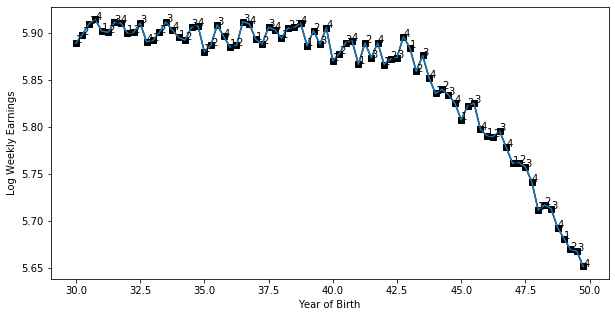

In [8]:
fgrs.plot_log_wkly_earnings_by_qob(df)

The figure shows, that men born in the first quarter, who have on average lower completed years of schooling, also seem to be more likely to have smaller weekly earnings. Moreover, the authors observe, that weekly earnings are correlated to age. While for the older generation, men born between 1930-39, the relation is positive but with a slight slope, the slope for the younger generation is clearly larger.
Since men born in the first quarter are older than men born in the other quarters, they will have higher earnings. This effect is smaller for older men, so Angrist and Krueger decide to focus their investigations on 40-49 year-old men.

The following tables present wald estimates on the return of education for two panels of 40-49 year-old men. Panel A uses data of men born between 1920-29 from the 1970 census and Panel B uses data of men born between 1930-39 from the 1980 census. The estimates compare the earnings of men born in the first quarter with men born in the other quarters.

In [9]:
df70 = dhlp.get_df_census70()
df70 = dhlp.add_quarter_of_birth_dummies(df70)
df70 = df70.loc[(df70['YOB'] >= 1920) & (df70['YOB'] <= 1929)]

df70_rslt = rgr.get_results_table_wald_estimates(df70)

HTML(tbl.create_table_wald_estimates('Panel A: Wald Estimates for 1970 Census - Men Born 1920-1929', df70_rslt))

In [10]:
df80 = dhlp.get_df_census80_extract()
df80 = dhlp.add_quarter_of_birth_dummies(df80)
df80 = df80.loc[(df80['YOB'] >= 30) & (df80['YOB'] <= 39)]

df80_rslt = rgr.get_results_table_wald_estimates(df80)

HTML(tbl.create_table_wald_estimates('Panel B: Wald Estimates for 1980 Census - Men Born 1930-1939', df80_rslt))

In Panel A men born in the first quarter have 0.0098 less log weekly wages and 0.1256 less years of completed education. The wald estimator provides 0.072 as estimate of the return to education. This estimate is consistent if season of birth is uncorrelated to influence factors of income except education. This condition is likely to be fullfilled, because unobserved determinants of income, like ability, are uniformely distributed across birthdays. The OLS estimate of the return to education 0.08 is slightly higher than the wald estimate.
Panel B provides an higher wald estimate of the return to education: 0.102. The OLS estimate is smaller: 0.071. 

In [11]:
print("Panel A 95% confidence intervals")
print("wald estimate : [{0}, {1}]".format(df70_rslt['wald_est'] - 1.96 * df70_rslt['wald_err'], \
                                          df70_rslt['wald_est'] + 1.96 * df70_rslt['wald_err']))
print("ols estimate : [{0}, {1}]".format(df70_rslt['ols_est'] - 1.96 * df70_rslt['ols_err'], \
                                         df70_rslt['ols_est'] + 1.96 * df70_rslt['ols_err']))



print("\nPanel B 95% confidence intervals")
print("wald estimate : [{0}, {1}]".format(df80_rslt['wald_est'] - 1.96 * df80_rslt['wald_err'], \
                                           df80_rslt['wald_est'] + 1.96 * df80_rslt['wald_err']))
print("ols estimate : [{0}, {1}]".format(df80_rslt['ols_est'] - 1.96 * df80_rslt['ols_err'], \
                                         df80_rslt['ols_est'] + 1.96 * df80_rslt['ols_err']))

Panel A 95% confidence intervals
wald estimate : [0.024497983393132382, 0.11852863381025316]
ols estimate : [0.07941554224389986, 0.08080682433206575]

Panel B 95% confidence intervals
wald estimate : [0.052664177388578294, 0.1513258150060131]
ols estimate : [0.07018736848184977, 0.071514707106674]


Calculation of the confidence intervals yields that the differences between wald and OLS estimate are not statistically significant.

<h3>TSLS Estimates</h3>

For further analysis of the return to education Angrist and Krueger present various two-stage-least-squares applications. The estimated TSLS model is the following

$$ E_{i} = X_{i}\pi + \sum_{c}{Y_{ic}\delta_{c}} + \sum_{c}{\sum_{j}{Y_{ic}Q_{ij}\theta_{jc}}} + \epsilon_{i} $$

$$ ln\space W_{i} = X_{i}\beta + \sum_{c}{Y_{ic}\xi_{c}} + \rho E_{i} + \mu_{i} $$

$E_{i}$ is the education of individual $i$, $X_{i}$ is a vector of covariates, $Q_{ij}$ is a dummy variable for birth in quarter $j$ (with $j=1,2,3$), and $Y_{ic}$ is a dummy-variable indicating in which year c the individual was born (with $c=1,\dots, 10$), and $W_{i}$ is the weekly wage. The coefficient $\rho$ is the return to education.
Excluded instruments of the wage equation are the three quarter of birth dummies interacted with nine year of birth dummies. The effect of age on wage is controlled by the nine year-of-birth dummies in both equations. So the effect of education is solely identified by the variation in quarter of birth.

The following tables show the results of multiple two-stage-least-squares estimations for various cohorts and specifications. For each specification a TSLS and an OLS regression are presented.
OLS and TSLS results in the first two columns using year-of-birth dummies to control for year-of-birth effects. In the next to columns an age and a quadratic age term are added.
The last four columns repeat this procedure with race dummies, dummy of residence in SMSA, martial status dummy and eight region-of-residence dummies added.

The first table uses data from the 1970 census of men born between 1920-29.

In [12]:
df70 = dhlp.get_df_census70()
df70 = df70.loc[(df70['YOB'] >= 1920) & (df70['YOB'] <= 1929)]

rslt = rgr.get_regression_results_ols_tls(df70)
HTML(tbl.create_table_ols_tls(rslt))

,(1),(2),(3),(4),(5),(6),(7),(8)
Independent variable,OLS,TSLS,OLS,TSLS,OLS,TSLS,OLS,TSLS
Years of education,0.0802,0.0769,0.0802,0.1310,0.0701,0.0669,0.0701,0.1007
,(0.0004),(0.0165),(0.0004),(0.0352),(0.0004),(0.0162),(0.0004),(0.0354)
Race (1 = black),-,-,-,-,-0.2980,-0.3055,-0.2980,-0.2271
,,,,,(0.0043),(0.0379),(0.0043),(0.0822)
SMSA (1 = center city),-,-,-,-,-0.1343,-0.1362,-0.1343,-0.1163
,,,,,(0.0026),(0.0099),(0.0026),(0.0210)
Married (1 = married),-,-,-,-,0.2928,0.2941,0.2928,0.2804
,,,,,(0.0037),(0.0077),(0.0037),(0.0150)
9 Year-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


The second table uses data from the 1980 census for men born between 1930-39.

In [14]:
df80 = dhlp.get_df_census80_extract()
df80 = df80.loc[(df80['YOB'] >= 30) & (df80['YOB'] <= 39)]

rslt = rgr.get_regression_results_ols_tls(df80)
HTML(tbl.create_table_ols_tls(rslt))

,(1),(2),(3),(4),(5),(6),(7),(8)
Independent variable,OLS,TSLS,OLS,TSLS,OLS,TSLS,OLS,TSLS
Years of education,0.0711,0.0891,0.0711,0.0760,0.0632,0.0806,0.0632,0.0600
,(0.0003),(0.0171),(0.0003),(0.0308),(0.0003),(0.0172),(0.0003),(0.0305)
Race (1 = black),-,-,-,-,-0.2575,-0.2302,-0.2575,-0.2626
,,,,,(0.0040),(0.0274),(0.0040),(0.0482)
SMSA (1 = center city),-,-,-,-,-0.1763,-0.1581,-0.1763,-0.1797
,,,,,(0.0029),(0.0182),(0.0029),(0.0321)
Married (1 = married),-,-,-,-,0.2479,0.2440,0.2479,0.2486
,,,,,(0.0032),(0.0051),(0.0032),(0.0076)
9 Year-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


The third table uses data from the 1980 census for men born between 1940-49.

In [15]:
df80 = dhlp.get_df_census80_extract()
df80 = df80.loc[(df80['YOB'] >= 40) & (df80['YOB'] <= 49)]

rslt = rgr.get_regression_results_ols_tls(df80)
HTML(tbl.create_table_ols_tls(rslt))

,(1),(2),(3),(4),(5),(6),(7),(8)
Independent variable,OLS,TSLS,OLS,TSLS,OLS,TSLS,OLS,TSLS
Years of education,0.0573,0.0553,0.0573,0.0948,0.0520,0.0393,0.0521,0.0779
,(0.0003),(0.0143),(0.0003),(0.0227),(0.0003),(0.0149),(0.0003),(0.0244)
Race (1 = black),-,-,-,-,-0.2107,-0.2266,-0.2108,-0.1786
,,,,,(0.0032),(0.0189),(0.0032),(0.0305)
SMSA (1 = center city),-,-,-,-,-0.1418,-0.1535,-0.1419,-0.1182
,,,,,(0.0023),(0.0139),(0.0023),(0.0225)
Married (1 = married),-,-,-,-,0.2445,0.2442,0.2444,0.2450
,,,,,(0.0022),(0.0023),(0.0022),(0.0023)
9 Year-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


<h3>Allowing the Seasonal Pattern in Education to Vary by State of Birth</h3>

School start age policy varies among states in the US causing different relationships between compulsory schooling and season of birth in different states. This additional variation is used in the following TSLS estimations by adding three quarter-of-birth dummies interacted with fifty state-of-birth as instruments, additionally to the three quarter-of-birth dummies interacted with nine year-of-birth dummies. Fifty state-of-birth dummies are also added to the wage equation. Unlike in the previous estimations, differences in season of birth are allowed to vary by state, additionaly to the variation by year.
The following table uses data from the 1980 census for men born between 1930-39.

In [16]:
###
# Problems with memory can occur
###

df80 = dhlp.get_df_census80_extract()
df80 = df80.loc[(df80['YOB'] >= 30) & (df80['YOB'] <= 39)]

rslt = rgr.get_regression_results_ols_tls(df80, state_of_birth_dummies = True)
HTML(tbl.create_table_ols_tls(rslt, state_of_birth_dummies = 50))

,(1),(2),(3),(4),(5),(6),(7),(8)
Independent variable,OLS,TSLS,OLS,TSLS,OLS,TSLS,OLS,TSLS
Years of education,0.0673,0.0928,0.0673,0.0907,0.0628,0.0831,0.0628,0.0811
,(0.0003),(0.0097),(0.0003),(0.0112),(0.0003),(0.0099),(0.0003),(0.0114)
Race (1 = black),-,-,-,-,-0.2547,-0.2333,-0.2547,-0.2354
,,,,,(0.0043),(0.0114),(0.0043),(0.0128)
SMSA (1 = center city),-,-,-,-,-0.1705,-0.1511,-0.1705,-0.1531
,,,,,(0.0029),(0.0099),(0.0029),(0.0112)
Married (1 = married),-,-,-,-,0.2487,0.2435,0.2487,0.2441
,,,,,(0.0032),(0.0042),(0.0032),(0.0044)
9 Year-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


The results of the OLS estimations of return to education are smaller than the previous estimates. The other way around, TSLS estimates are increased. Therefore, the difference between OLS and TSLS is slightly higher. The standard errors of TSLS are smaller than in the previous regressions.

<h3>Estimates for Black Men</h3>

There are findings in the literature, that the return of education is lower for black men then for white men(WELCH 1973). Part of the explanation seems to be that black men have only access to lower quality schools. Therefore, return to education is expected to be smaller for black workers.
The following table shows results for a subset containing only black men of the cohort of men born between 1930-39. The results are obtained running the same OLS and TSLS estimations as in the previous section.

In [2]:
###
# Problems with memory can occur
###
df = dhlp.get_df_census80_extract()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
df = df.loc[df['RACE'] == 1]
df = df.drop(df.loc[df['STATE'] == 15].index)

rslt = rgr.get_regression_results_ols_tls(df, state_of_birth_dummies = True, race = False)
HTML(tbl.create_table_ols_tls(rslt, state_of_birth_dummies = 49, race = False))

,(1),(2),(3),(4),(5),(6),(7),(8)
Independent variable,OLS,TSLS,OLS,TSLS,OLS,TSLS,OLS,TSLS
Years of education,0.0672,0.0635,0.0671,0.0555,0.0576,0.0461,0.0576,0.0391
,(0.0013),(0.0193),(0.0013),(0.0208),(0.0013),(0.0193),(0.0013),(0.0205)
SMSA (1 = center city),-,-,-,-,-0.1885,-0.2053,-0.1884,-0.2155
,,,,,(0.0142),(0.0318),(0.0142),(0.0334)
Married (1 = married),-,-,-,-,0.2216,0.2272,0.2216,0.2307
,,,,,(0.0100),(0.0140),(0.0100),(0.0145)
9 Year-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
8 Region-of-residence dummies,No,No,No,No,Yes,Yes,Yes,Yes
49 State-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


The TSLS estimates for return of education for black men are smaller than for the entire male population. The OLS estimates also decrease in the estimations using dummies for residence in a SMSA, martial status and region of residence. The standard errors of the OLS estimates increase because the sample size decreases to 26,913 records instead of 329,509.

<h2>6. Extensions</h2>

<h3>Problems with Multicollinearity</h3>

<h3>Variance Inflation Factor</h3>


In [15]:
df = dhlp.get_df_census80_extract()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
df = dhlp.prepare_census_data(df)

X = patsy.dmatrix(' + '.join(rgr.get_quarter_of_birth_dummy_names() + \
                             rgr.get_year_of_birth_dummy_names() + \
                             rgr.get_age_control_names() + \
                             rgr.get_region_of_residence_dummies() + \
                             rgr.get_further_exogenous_regressors()),
                   df, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round(1)

D:\Softwareentwicklung\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
D:\Softwareentwicklung\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,0.0,Intercept
1,inf,DUMMY_QOB_1
2,inf,DUMMY_QOB_2
3,inf,DUMMY_QOB_3
4,inf,DUMMY_YOB_0
5,inf,DUMMY_YOB_1
6,inf,DUMMY_YOB_2
7,inf,DUMMY_YOB_3
8,inf,DUMMY_YOB_4
9,inf,DUMMY_YOB_5


<h3>Local Average Treatment Effect</h3>

<h3>Problems with Weak Instruments</h3>

<h4>Inconsistency</h4>

Bound et. al (1995) present that a weak correlation between instruments and the endogenous variable can lead to inconsistency problems. Because given a week correlation also small correlations between instruments and error can cause a larger incosistency in instrumental variable estimates than in OLS estimates.

In [11]:
df = dhlp.get_df_census80_extract()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
df = dhlp.add_quarter_of_birth_dummies(df)
rslt = smf.ols(formula = 'EDUC ~ ' + ' + '.join(rgr.get_quarter_of_birth_dummy_names()), data = df).fit()

print(f'R-Squared: {rslt.rsquared:7.6f}')

R-Squared: 0.000310


For the 1930-39 cohort the association between quarter of birth and education is weak. Quarter of birth dummies can only explain 0.031% of the variation in completed year of schooling. Therefore, estimations using quarter of birth as an instrument could be biased, if there are other associations between quarter of birth and wage than the association through education.

Bound et al. present several findings in literature, which suggest that such an association could exist.
<ul>
    <li>quarter of birth could effect student's performance in school</li>
    <li>differences in physical and mental health at different birthdays</li>
    <li>regional patterns in birth seasonality</li>
    <li>childrens of families with high income are less likely to be born in winter months</li>
</ul>
Existence of these associations would bias the estimations of the instrumental variables approach. Bound et al. emphasize that this bias could be large even if the association is small since the correlation between quarter of birth and education is also small. Although there is no clear evidence for one of the associations, the findings in the literature weaken the results made by Angrist and Krueger.

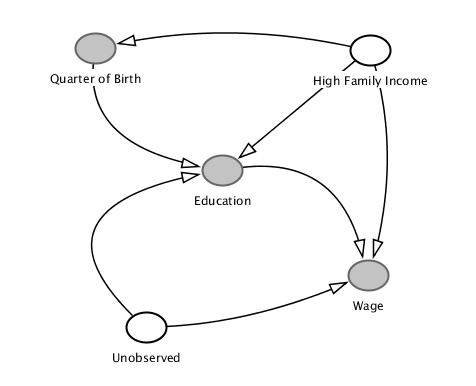

In [13]:
Image('files/causal_graph_weak_instruments.png')

Bound et al. also revisit the result of Table V from the Angrist and Krueger paper. Adding controls for race, residence in a SMSA and martial status to the OLS results in column (3) reduces the estimated effect of education from 0.0711 to 0.0632. Adding these controls to the TSLS results in column (4) reduces the the effect from 0.0760 to 0.0600. This implies an percentual change of 11% for OLS and 21% for TSLS. The large drop in the estimation results for two stage least squares indicate a association between quarter of birth and the controls. 

In [12]:
for i in range(1, 5):
    frac = len(df.loc[(df['RACE'] == 1) & (df['QOB'] == i)]) / len(df[df['RACE'] == 1])
    print(f'Fraction of black men born in quarter {i}: {frac:4.3f}')

print()
    
for i in range(1, 5):
    frac = len(df.loc[(df['RACE'] == 0) & (df['QOB'] == i)]) / len(df[df['RACE'] == 0])
    print(f'Fraction of white men born in quarter {i}: {frac:4.3f}')


print('\nMean education of white men: {:4.2f}'.format(df[df['RACE'] == 0]['EDUC'].mean()))
print('Mean education of black men: {:4.2f}'.format(df[df['RACE'] == 1]['EDUC'].mean()))

print('\nMean income of white men: {:4.2f}'.format(df[df['RACE'] == 0]['LWKLYWGE'].mean()))
print('Mean income of black men: {:4.2f}'.format(df[df['RACE'] == 1]['LWKLYWGE'].mean()))

Fraction of black men born in quarter 1: 0.254
Fraction of black men born in quarter 2: 0.248
Fraction of black men born in quarter 3: 0.256
Fraction of black men born in quarter 4: 0.241

Fraction of white men born in quarter 1: 0.247
Fraction of white men born in quarter 2: 0.243
Fraction of white men born in quarter 3: 0.264
Fraction of white men born in quarter 4: 0.246

Mean education of white men: 12.90
Mean education of black men: 11.25

Mean income of white men: 5.93
Mean income of black men: 5.54


Bound et al. present different patterns in birth quarters for black and white men as possible source for associations between quarter of birth and the quarter of birth. Black men are more likely to be born in the first quarter than white men while white men are more likely to be born in the third quarter. Since the average income and education of black men is smaller, race contributes to lower education and wage in the first quarter.

Although the correlation between quarter of  birth and race is quite small, including race control varibles in the estimation leads to clear differences in the estimated effect.

In [13]:
df[dhlp.get_quarter_of_birth_dummy_names() + ['RACE']].corr()

,DUMMY_QOB_1,DUMMY_QOB_2,DUMMY_QOB_3,RACE
DUMMY_QOB_1,1.00e+00,-3.25e-01,-3.43e-01,4.53e-03
DUMMY_QOB_2,-3.25e-01,1.00e+00,-3.39e-01,3.19e-03
DUMMY_QOB_3,-3.43e-01,-3.39e-01,1.00e+00,-4.91e-03
RACE,4.53e-03,3.19e-03,-4.91e-03,1.00e+00


<h4>Finite-Sample Bias</h4>

Bound et. al state that the results of Angrist and Krueger could include a finite-sample bias in spite of the huge sample size, because of the weak correlation between education and quarter of birth. They reproduce the estimations while adding F-statistics for the joint statistical significance of the excluded instruments and the partial $R^{2}$ for the excluded instruments. Also, Basmann's (1960) F test for overidentification is added.

In [32]:
df = dhlp.get_df_census80_extract()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]

df = dhlp.prepare_census_data(df, qob_x_yob = True)
model = rgr.get_model_weak_instruments_table_1()

results = rgr.run_model_iv2sls(df, model)
f_test = rgr.f_test_excluded_instruments(df, model)
r_squared = rgr.partial_r_squared_excluded_instruments(df, model)

HTML(tbl.create_weak_instruments_table_1(results, f_test, r_squared))

,(1),(2),(3),(4),(5),(6)
,OLS,IV,OLS,IV,OLS,IV
Coefficient,0.0632,0.1422,0.0632,0.0806,0.0632,0.0600
,(0.0004),(0.0331),(0.0004),(0.0165),(0.0004),(0.0292)
F(excluded instruments),,13.4856,,4.7474,,2.6149
Parital R squared (excluded instruments),,0.0001,,0.0004,,0.0001
F(overidentification),,0.9257,,0.7016,,0.6112
Age Control Variables,,,,,,
"Age, age squared",x,x,,,x,x
9 Year of birth dummies,,,x,x,x,x
,,,,,,


All specification include race, SMSA and martial status dummies, and also eight region of residence dummies. For each specification OLS and IV estimates are presented. The first two specifications include control variables for age and age squared. Excluded instruments are quarter of birth dummies. 

In [5]:
df = dhlp.get_df_census80_extract()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]

state_list = dhlp.get_state_list(df)

df = dhlp.prepare_census_data(df, qob_x_yob = True, qob_x_state = state_list)
model = rgr.get_model_weak_instruments_table_2(state_list)

results = rgr.run_model_iv2sls(df, model)
f_test = rgr.f_test_excluded_instruments(df, model)
r_squared = rgr.partial_r_squared_excluded_instruments(df, model)

HTML(tbl.create_weak_instruments_table_2(results, f_test, r_squared))

<h4>The Bias of 2SLS</h4>

In Angrist (2009) the author revisits the results from Angrist and Krueger (1991) discussing the critics of Bound, Jaeger and Baker (1995). 

In [7]:
df = dhlp.get_df_census80_extract()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
state_list = dhlp.get_state_list(df)

df = dhlp.prepare_census_data(df, qob_x_yob = True, qob_x_state = state_list)
model = rgr.get_model_mstly_hrmlss_ecnmtrcs_table_4_6_2(state_list)

tsls = rgr.run_model_iv2sls(df, model)
liml = rgr.run_model_ivliml(df, model)
f_test = rgr.f_test_excluded_instruments(df, model)

HTML(tbl.create_table_mstly_hrmlss_ecnmtrcs_4_6_2(tsls, liml, f_test))

# 7. Conclusion

# 8. References